In [10]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [11]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col='id')

In [12]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [13]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [20]:
def get_freqs(df):
    freqs = defaultdict(int)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

In [21]:
def get_feature(text, fregs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += fregs[(token, 0)]
        X[2] += fregs[(token, 1)]
    
    return X

In [22]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [24]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [25]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [26]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    return sigmoid(X @ theta)

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return np.mean(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))

def compute_gradient(X, y, y_hat):
    return X.T @ (y_hat - y) / y.shape[0]

def update_theta(theta, grad, lr):
    return theta - lr * grad

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc

In [27]:
lr = 0.01
epochs = 200
batch_size = 16

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [28]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

        y_hat_val = predict(X_val, theta)
        val_loss = compute_loss(y_hat_val, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    train_batch_loss = np.mean(train_batch_losses)
    val_batch_loss = np.mean(val_batch_losses)
    train_batch_acc = np.mean(train_batch_accs)
    val_batch_acc = np.mean(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.594	Validation loss: 0.593

EPOCH 2:	Training loss: 0.477	Validation loss: 0.475

EPOCH 3:	Training loss: 0.441	Validation loss: 0.439

EPOCH 4:	Training loss: 0.426	Validation loss: 0.423

EPOCH 5:	Training loss: 0.416	Validation loss: 0.414

EPOCH 6:	Training loss: 0.410	Validation loss: 0.407

EPOCH 7:	Training loss: 0.405	Validation loss: 0.402

EPOCH 8:	Training loss: 0.401	Validation loss: 0.398

EPOCH 9:	Training loss: 0.398	Validation loss: 0.394

EPOCH 10:	Training loss: 0.395	Validation loss: 0.391

EPOCH 11:	Training loss: 0.393	Validation loss: 0.389

EPOCH 12:	Training loss: 0.391	Validation loss: 0.387

EPOCH 13:	Training loss: 0.389	Validation loss: 0.385

EPOCH 14:	Training loss: 0.387	Validation loss: 0.384

EPOCH 15:	Training loss: 0.386	Validation loss: 0.382

EPOCH 16:	Training loss: 0.385	Validation loss: 0.381

EPOCH 17:	Training loss: 0.384	Validation loss: 0.380

EPOCH 18:	Training loss: 0.383	Validation loss: 0.379

EPOCH 19:	Training

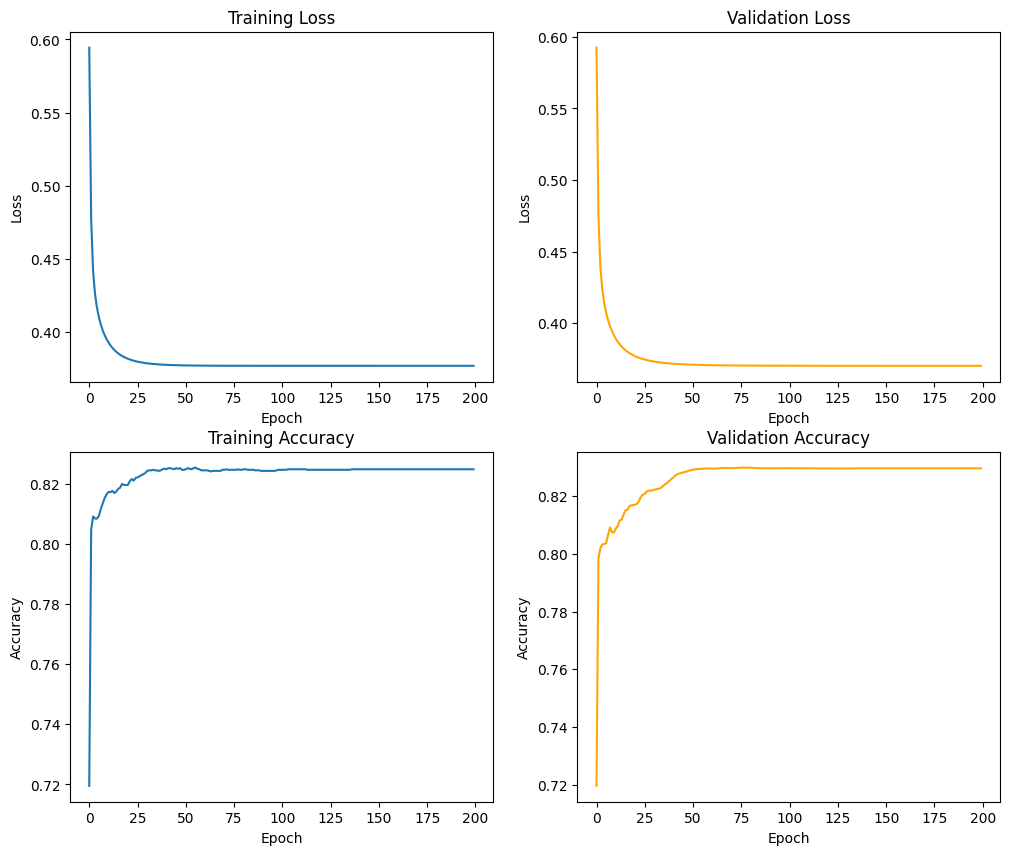

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss Plot
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss Plot
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy Plot
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy Plot
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [30]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation Accuracy: {val_set_acc}')
print(f'Test Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Validation Accuracy: 0.8308080808080808
Test Accuracy: 0.8434343434343434
